In [1]:
!git clone https://github.com/milesperry81/Data.git

Cloning into 'Data'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 54 (delta 21), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (54/54), done.


In [0]:
# Import the required packages.
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set randown seed values.
tf.random.set_seed(51)
np.random.seed(51)

# Import the individual csv files.
df1 = pd.read_csv('/content/Data/Prices_2016_09_2017_02.csv')
df2 = pd.read_csv('/content/Data/Prices_2017_03_2017_08.csv')
df3 = pd.read_csv('/content/Data/Prices_2017_09_2018_02.csv')
df4 = pd.read_csv('/content/Data/Prices_2018_03_2018_08.csv')
#df5 = pd.read_csv('/content/Data/Prices_2018_09_2019_01.csv')
#df1.head()

In [0]:
# Extract the required columns from the CSV files before concatenating them.
df1_loc = df1.loc[:, 'Site':'28/02/2017']
df2_loc = df2.loc[:, '1/03/2017':'31/08/2017']
df3_loc = df3.loc[:, '1/09/2017':'28/02/2018']
df4_loc = df4.loc[:, '1/03/2018':'31/08/2018']
#df5_loc = df5.loc[:, '1/09/2018':'31/01/2019']

# Concatenate the CSV data into a single data frame.
#df = pd.concat([df1_loc, df2_loc, df3_loc, df4_loc, df5_loc], axis=1, sort=True)
df = pd.concat([df1_loc, df2_loc, df3_loc, df4_loc], axis=1, sort=True)

In [0]:
# Remove rows the data with zero values in the first column.
sites_index = []

for i in range(df.shape[0]):
  #Find index of sites with zero value to start.
  if df.loc[i][1] == 0.00:
    sites_index.append(i)

# Drop sites with zero starting price.
df = df.drop(sites_index)

In [9]:
# Reset the index after removing data with zeros
df = df.reset_index(drop=True)
df.head()

,Site,1/09/2016,2/09/2016,3/09/2016,4/09/2016,5/09/2016,6/09/2016,7/09/2016,8/09/2016,9/09/2016,10/09/2016,11/09/2016,12/09/2016,13/09/2016,14/09/2016,15/09/2016,16/09/2016,17/09/2016,18/09/2016,19/09/2016,20/09/2016,21/09/2016,22/09/2016,23/09/2016,24/09/2016,25/09/2016,26/09/2016,27/09/2016,28/09/2016,29/09/2016,30/09/2016,1/10/2016,2/10/2016,3/10/2016,4/10/2016,5/10/2016,6/10/2016,7/10/2016,8/10/2016,9/10/2016,...,23/07/2018,24/07/2018,25/07/2018,26/07/2018,27/07/2018,28/07/2018,29/07/2018,30/07/2018,31/07/2018,1/08/2018,2/08/2018,3/08/2018,4/08/2018,5/08/2018,6/08/2018,7/08/2018,8/08/2018,9/08/2018,10/08/2018,11/08/2018,12/08/2018,13/08/2018,14/08/2018,15/08/2018,16/08/2018,17/08/2018,18/08/2018,19/08/2018,20/08/2018,21/08/2018,22/08/2018,23/08/2018,24/08/2018,25/08/2018,26/08/2018,27/08/2018,28/08/2018,29/08/2018,30/08/2018,31/08/2018
0,7-Eleven Adamstown,98.9,98.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,129.9,129.9,129.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,100.9,100.9,100.9,100.9,100.9,100.9,100.9,100.9,131.9,131.9,131.9,131.9,131.9,...,151.1,150.7,150.7,149.9,147.9,146.9,146.5,146.5,146.5,146.5,144.5,143.4,141.4,141.4,139.9,139.9,139.9,139.9,139.9,158.9,158.9,158.9,159.4,159.4,159.4,159.4,159.4,159.4,159.4,159.4,159.4,159.4,159.4,159.4,159.4,159.4,159.4,159.4,157.9,151.9
1,7-Eleven Albion Park Rail,105.7,105.7,105.7,105.7,105.7,105.7,101.9,101.9,127.4,127.4,126.9,124.9,123.9,122.9,120.9,114.9,112.7,112.7,112.7,112.7,111.9,106.4,106.4,131.9,131.9,131.4,131.4,131.4,131.4,129.9,126.3,125.9,125.9,125.9,123.4,121.9,118.4,117.4,115.4,...,135.9,133.9,131.9,131.9,131.9,131.9,131.9,131.9,131.9,130.9,130.9,130.9,129.9,129.9,129.9,159.4,159.4,157.9,157.9,156.9,156.9,156.9,154.9,154.9,149.9,146.9,143.9,139.4,137.9,136.9,135.9,135.9,135.9,135.9,135.9,135.9,132.9,159.9,159.4,154.9
2,7-Eleven Argenton,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,129.9,128.9,128.9,128.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,101.9,131.9,131.9,129.4,128.9,128.9,...,151.9,151.9,151.9,149.9,147.9,146.9,145.9,145.9,145.9,145.9,145.9,145.9,145.9,145.9,145.9,145.9,145.9,145.9,159.4,158.9,158.9,158.9,158.9,158.9,158.9,155.9,155.9,155.9,155.9,155.9,155.9,152.9,152.9,152.9,152.9,152.9,152.9,152.9,152.9,152.9
3,7-Eleven Arncliffe,107.7,103.9,103.9,103.9,103.9,101.9,101.9,129.9,127.4,127.4,126.9,125.9,122.9,119.9,115.9,115.9,115.9,115.9,113.9,108.9,107.5,106.1,104.3,131.4,131.4,129.9,129.9,129.9,129.9,129.9,125.9,125.9,119.9,119.9,118.9,110.9,110.7,110.7,108.9,...,136.9,135.9,133.9,131.9,131.9,130.9,129.9,128.7,128.7,128.7,127.9,127.7,159.4,159.4,159.4,159.4,159.4,153.9,149.9,149.9,148.9,148.9,143.9,142.9,142.9,139.9,137.9,135.9,133.9,132.9,131.9,131.9,131.9,131.9,159.9,159.9,159.9,159.9,159.4,158.9
4,7-Eleven Arndell Park,103.9,103.9,103.9,103.9,101.9,101.9,101.9,101.9,127.4,127.4,125.9,125.9,118.9,115.9,115.9,112.9,112.9,112.9,110.9,109.9,107.4,131.9,103.9,131.9,131.9,131.4,129.9,129.9,129.9,129.9,120.9,120.9,118.9,118.9,115.4,112.9,112.9,109.9,107.9,...,137.7,135.9,134.4,131.9,129.7,129.7,129.7,129.7,129.3,128.7,128.3,128.3,127.9,127.9,159.4,159.4,159.4,157.9,155.9,154.9,154.9,154.9,154.9,154.9,151.9,147.9,142.9,142.9,139.9,135.9,133.9,132.9,131.9,131.9,131.9,159.9,159.9,159.9,159.4,159.4


In [10]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 1/09/2016 to 31/08/2018


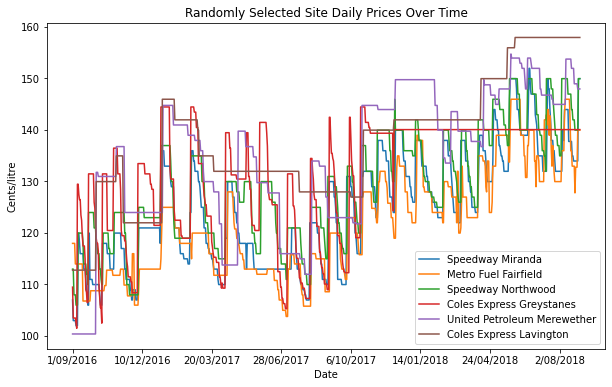

In [11]:
# Function to plot time series data.
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    page_labels = sample['Site'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        pd.Series(series_samples.iloc[i]).astype(np.float64).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Site Daily Prices Over Time')
    plt.legend(page_labels)
    plt.xlabel("Date")
    plt.ylabel("Cents/litre")
    
plot_random_series(df, 6)

In [0]:
from datetime import timedelta

# Size of the prediction interval.
pred_steps = 60

# Size of the historic data input windows.
window = 600

pred_length = timedelta(pred_steps)
window_length = timedelta(window) 

# Find first and last date of the dateset.
first_day = pd.to_datetime(data_start_date, dayfirst=True) # convert to date and time.
last_day = pd.to_datetime(data_end_date, dayfirst=True) # convert to date and time.

# Find start of the final prediction window.
final_pred_start = last_day - pred_length + timedelta(1) # end - X days + 1 day.

# Find start and end of the final historic data window.
final_history_start = final_pred_start - window_length
final_history_end = final_pred_start - timedelta(1)

In [0]:
# Ensure there are no milleseconds on the timestamps. 

first_day = first_day.strftime("%Y-%m-%d %H:%M:%S")
last_day = last_day.strftime("%Y-%m-%d %H:%M:%S")

final_pred_start = final_pred_start.strftime("%Y-%m-%d %H:%M:%S")

final_history_start = final_history_start.strftime("%Y-%m-%d %H:%M:%S")
final_history_end = final_history_end.strftime("%Y-%m-%d %H:%M:%S")

In [14]:
print("Last history window:",final_history_start, '-',final_history_end)
print('Last prediction window:', final_pred_start, '-', last_day)

print('\nHistoric window interval:', window_length.days)
print('Prediction interval:', pred_length.days)

Last history window: 2016-11-10 00:00:00 - 2018-07-02 00:00:00
Last prediction window: 2018-07-03 00:00:00 - 2018-08-31 00:00:00

Historic window interval: 600
Prediction interval: 60


In [0]:
# Create indicies from the date column headings.
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c,dayfirst=True) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

# Function to split the main data series into training, validation and test.
def split_series(series_array, split = 0.1):

    split_num_val = int(series_array.shape[0]-((series_array.shape[0]*split)*2))
    split_num_test = int(series_array.shape[0]-(series_array.shape[0]*split))

    train_series = series_array[:split_num_val,:]
    validation_series = series_array[split_num_val:split_num_test,:]
    test_series = series_array[split_num_test:,:]
    
    return train_series, validation_series, test_series

# Function to pull a time frame of data from a series array.
def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    # Find indicies for the requested date range.
    inds = date_to_index[start_date:end_date]
    # Return the data series for the relevant date range using the indicies.
    return series_array[:,inds]

# Function to normalise a series array for training.
def transform_series_train(series_array):
       
    series_mean = series_array.mean().reshape(-1,1)
    series_std = series_array.std().reshape(-1,1)
    series_array = (series_array - series_mean)/series_std
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))

    return series_array, series_mean, series_std

# Function to normalise a series array using the mean and std dev from training.
def transform_series_other(series_array, train_series_mean, train_series_std):
    
    series_array = (series_array - train_series_mean)/train_series_std
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [16]:
#Create numpy array of the series values.
series_array = df[df.columns[1:]].values

#Shuffle the array.
np.random.shuffle(series_array)

# Create a series array from the data using the last historic window and prediction 
# intervals. This data will be shared amongst the validation and test data. These time
# period will be unseen by the algorithm during training. 
unseen_data = get_time_block_series(series_array, date_to_index, final_history_start, last_day)

# The time periods will be segmented into train, validation and test data. 
seen_data = get_time_block_series(series_array, date_to_index, first_day, final_history_end)

print("Shape of unseen data: ",unseen_data.shape)
print("Shape of seen data: ",seen_data.shape)

Shape of unseen data:  (1307, 660)
Shape of seen data:  (1307, 670)


In [17]:
# Create more windows of data from the seen data series.

# Function to segment the data into smaller time windows.
def walk_forward(series,window_size,prediction_steps,increment_steps=2):
  
  # Determine the number of forward steps we can take when creating a new series of data.
  forward_steps = series.shape[1]-(window_size+prediction_steps)

  # Assign the first set of data series to the new series array.
  new_series = series[:,:window_size+prediction_steps]

  # Take steps forward in time to create more time windows.
  for i in range(increment_steps,forward_steps,increment_steps):
      new_series = np.concatenate((new_series, series[:,i:i+window_size+prediction_steps]), axis=0)

  return new_series

# Run the walk forward segmentation.
new_series = walk_forward(seen_data,window,pred_steps,1)

# Shuffle the newly segmented data.
np.random.shuffle(new_series)

print("Pre segmentation series dimension: ",seen_data.shape)
print("Post segmentation series dimension: ",np.array(new_series).shape)

Pre segmentation series dimension:  (1307, 670)
Post segmentation series dimension:  (13070, 660)


In [0]:
# Split the train and validation series from each other.
train_series, validation_series, test_series = split_series(new_series, split = 0.1)

# Split the unseen data in half and then add to validation and test.
unseen_split = unseen_data.shape[0]//2

# Add unseen data to the validation and test series.
validation_series = np.concatenate((validation_series, unseen_data[:unseen_split,:]), axis=0)
test_series = np.concatenate((test_series, unseen_data[unseen_split:,:]), axis=0)

#TRAINING DATA INPUTS AND TARGETS

# Normalise the training input data.
train_input_data, train_series_mean, train_series_std = transform_series_train(train_series[:,:window])
# Normalise the training target data.
train_target_data = transform_series_other(train_series[:,window:], train_series_mean, train_series_std)

#VALIDATION DATA INPUTS AND TARGETS.

# Normalise the validation input data.
validation_input_data = transform_series_other(validation_series[:,:window],train_series_mean, train_series_std)
# Normalise the validation target data.
validation_target_data = transform_series_other(validation_series[:,window:], train_series_mean, train_series_std)

In [19]:
#Training history (m,time_steps,1)
print("Shape of the training history: ",train_input_data.shape)
#Training targets (m,pred_steps,1)
print("Shape of the training targets: ",train_target_data.shape)

#Validation history (m,time_steps,1)
print("Shape of the validation history: ",validation_input_data.shape)
#Validation targets (m,pred_steps,1)
print("Shape of the validation targets: ",validation_target_data.shape)

Shape of the training history:  (10456, 600, 1)
Shape of the training targets:  (10456, 60, 1)
Shape of the validation history:  (1960, 600, 1)
Shape of the validation targets:  (1960, 60, 1)


In [0]:
tf.keras.backend.clear_session()

# convolutional layer parameters
n_filters = 64
filter_width = 5
dilation_rates = [2**i for i in range(7)]*3 #(1,2,4,8,16,32,64,1,2,4,..)

# define an input layer for the network. 
history_seq = tf.keras.layers.Input(shape=(None, 1))
x = history_seq

# Store the output from the skip connections in this list.
skips = []

# Repeat the following bloack with different dilation rates
for dilation_rate in dilation_rates:
    
    # preprocessing - convert to 1D convolution.
    x = tf.keras.layers.Conv1D(32, 1, padding='same', activation='relu')(x)
    
    # dilated convolution
    x_d = tf.keras.layers.Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = tf.keras.layers.Multiply()([tf.keras.layers.Activation('relu')(x_d),
                    tf.keras.layers.Activation('sigmoid')(x_d)])
    
    # postprocessing - convert to 1D convolution.
    z = tf.keras.layers.Conv1D(32, 1, padding='same', activation='relu')(z)
    
    # residual connection - add input and out
    x = tf.keras.layers.Add()([x, z])    
    
    # Add some dropout to the more dilated layers.
    if dilation_rate >= 32:
      x = tf.keras.layers.Dropout(.1)(x)

    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = tf.keras.layers.Activation('relu')(tf.keras.layers.Add()(skips))

# final time-distributed dense layers 
out = tf.keras.layers.Conv1D(128, 1, padding='same')(out)
out = tf.keras.layers.Activation('relu')(out)
out = tf.keras.layers.Dropout(.2)(out)
out = tf.keras.layers.Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = tf.keras.layers.Lambda(slice, arguments={'seq_length':60})(out)

model = tf.keras.Model(history_seq, pred_seq_train)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

LEARNING_RATE = 1e-6
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)

model.compile(optimizer='adam', loss='mae')

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 32)     64          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     10304       conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, 64)     0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
# Define the tensorflow data pipelines with a shuffle buffer and batches.
BUFFER_SIZE = 10000
BATCH_SIZE = 128

train_univariate = tf.data.Dataset.\
                      from_tensor_slices((train_input_data, train_target_data))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).\
                      batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.\
            from_tensor_slices((validation_input_data, validation_target_data))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [0]:
# Run the model with learning rate schedule callbacks to find good value.

EPOCHS = 100
EVALUATION_INTERVAL = train_input_data.shape[0]//BATCH_SIZE

history = model.fit(train_univariate,
                    epochs=EPOCHS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                    validation_data=val_univariate,
                    validation_steps=50,
                    callbacks=[lr_schedule]
                    )

Epoch 1/100
81/81 [==============================] - 15s 179ms/step - loss: 1.7263 - val_loss: 1.7171 - lr: 1.0000e-06
Epoch 2/100
81/81 [==============================] - 12s 147ms/step - loss: 1.7172 - val_loss: 1.7055 - lr: 1.1220e-06
Epoch 3/100
81/81 [==============================] - 12s 146ms/step - loss: 1.7085 - val_loss: 1.6931 - lr: 1.2589e-06
Epoch 4/100
81/81 [==============================] - 12s 146ms/step - loss: 1.6939 - val_loss: 1.6798 - lr: 1.4125e-06
Epoch 5/100
81/81 [==============================] - 12s 146ms/step - loss: 1.6831 - val_loss: 1.6651 - lr: 1.5849e-06
Epoch 6/100
81/81 [==============================] - 12s 146ms/step - loss: 1.6698 - val_loss: 1.6477 - lr: 1.7783e-06
Epoch 7/100
81/81 [==============================] - 12s 146ms/step - loss: 1.6524 - val_loss: 1.6252 - lr: 1.9953e-06
Epoch 8/100
81/81 [==============================] - 12s 146ms/step - loss: 1.6354 - val_loss: 1.6001 - lr: 2.2387e-06
Epoch 9/100
81/81 [=============================

(1e-06, 1.0, 0.0, 2.0)

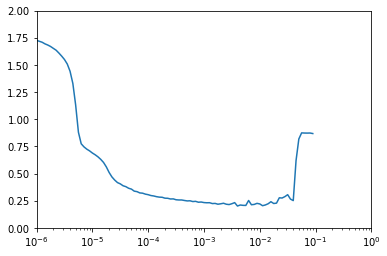

In [0]:
# Plot the sampled learning rates versus loss.
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-0, 0, 2]) 

In [23]:
# Run the model with the chosen learning rate
tf.keras.backend.clear_session()

LEARNING_RATE = 1e-3
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer='adam', loss='mae')

EPOCHS = 400
EVALUATION_INTERVAL = train_input_data.shape[0]//BATCH_SIZE
VALIDATION_STEPS = validation_input_data.shape[0]//BATCH_SIZE

history = model.fit(train_univariate,
                    epochs=EPOCHS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                    validation_data=val_univariate,
                    validation_steps=VALIDATION_STEPS)

Epoch 1/400
81/81 [==============================] - 12s 146ms/step - loss: 0.5894 - val_loss: 0.3874
Epoch 2/400
81/81 [==============================] - 10s 126ms/step - loss: 0.3287 - val_loss: 0.3420
Epoch 3/400
81/81 [==============================] - 10s 126ms/step - loss: 0.2923 - val_loss: 0.3373
Epoch 4/400
81/81 [==============================] - 10s 126ms/step - loss: 0.2680 - val_loss: 0.3130
Epoch 5/400
81/81 [==============================] - 10s 126ms/step - loss: 0.2579 - val_loss: 0.3099
Epoch 6/400
81/81 [==============================] - 10s 126ms/step - loss: 0.2465 - val_loss: 0.3161
Epoch 7/400
81/81 [==============================] - 10s 125ms/step - loss: 0.2380 - val_loss: 0.3104
Epoch 8/400
81/81 [==============================] - 10s 126ms/step - loss: 0.2289 - val_loss: 0.3014
Epoch 9/400
81/81 [==============================] - 10s 126ms/step - loss: 0.2217 - val_loss: 0.2803
Epoch 10/400
81/81 [==============================] - 10s 126ms/step - loss: 0.216

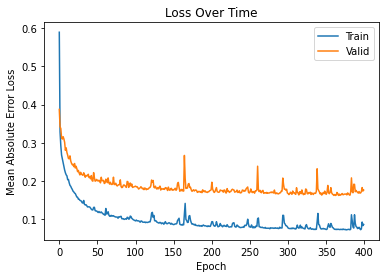

In [24]:
# Plot the training and validation loss per epoch.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [0]:
# Save model if required.
model.save("fuel_price_wavenet_inspired_final_400_epochs.h5")

# Load model from previous training run.
#model = tf.keras.models.load_model("fuel_price_wavenet_inspired_final_100_epochs.h5")

In [0]:
# Return the prediction sequence for historic input.
def predict_sequence(input_sequence):

    pred_sequence = model.predict(input_sequence)

    return pred_sequence

In [27]:
single_input = train_input_data[1012:1013,:,:]
single_pred = model.predict(single_input)

print("Input shape: ", single_input.shape)
print("Prediction shape:", single_pred.shape)


Input shape:  (1, 600, 1)
Prediction shape: (1, 60, 1)


In [0]:
# Function to plot single input, target and prediction.
def predict_and_plot(history_input_data, history_target_data, sample_ind, enc_tail_len=100):

    # Select a historic window from the validation time series. Must be 3D.
    history_series = history_input_data[sample_ind:sample_ind+1,:,:]

    # Returns the next X days predictions using the model.
    pred_series = predict_sequence(history_series)
    
    # Reshape history, predictions and targets from 3D to 2D arrays.
    history_series = history_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = history_target_data[sample_ind,:,:1].reshape(-1,1) 

    # Concatenate the last steps of the history, plus first prediction - make graph look continuous!
    history_series_tail = np.concatenate([history_series[-enc_tail_len:],target_series[:1]])
    # Shape of the first dimension of history tail.
    x_history = history_series_tail.shape[0]
    
    plt.figure(figsize=(6,4))   
    
    # Plot history.
    plt.plot(range(1,x_history+1),history_series_tail)
    # Plot the targets.
    plt.plot(range(x_history,x_history+pred_steps),target_series,color='orange')
    # Plot the predictions.
    plt.plot(range(x_history,x_history+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Historic Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Historic Series','Target Series','Predictions'])
    plt.xlabel('TIMESTEP')
    plt.ylabel('CENTS / LITRE')


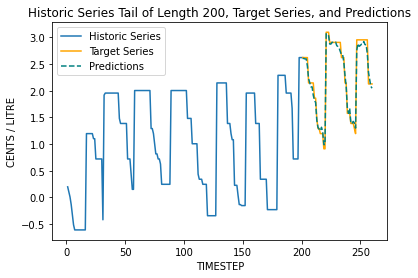

In [73]:
# Check some plots on the training data.
predict_and_plot(train_input_data, train_target_data, 1016, 200) #107

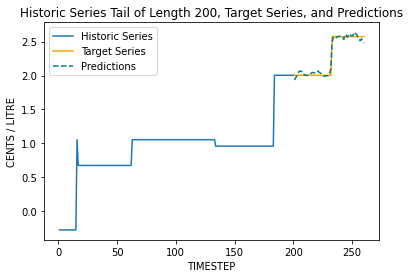

In [72]:
# Check some plots on the validation data.
predict_and_plot(validation_input_data, validation_target_data, 1023, 200)

In [31]:
# Create array of all day predictions for all the historic data windows.

#pred_array_train = predict_sequence_all(train_input_data)
#print(pred_array_train.shape)
#print(train_target_data.shape)

pred_array_validation = predict_sequence(validation_input_data)
print("Shape of validation predictions array: ",pred_array_validation.shape)
print("Shape of validation targets array: ",validation_target_data.shape)

Shape of validation predictions array:  (1960, 60, 1)
Shape of validation targets array:  (1960, 60, 1)


In [32]:
# Mean absolute error of the normalised data.
#print("Mean absolute error TRAIN = ",np.mean(np.abs(np.subtract(train_target_data[:10000],\
                                          #pred_array_train))))

print("Mean absolute error VAL normalised = ",np.mean(np.abs(np.subtract(validation_target_data[:10000],\
                                          pred_array_validation))))

Mean absolute error VAL normalised =  0.1812482379826038


In [0]:
# You need to back out the std dev and mean to get the price values.
def transform_to_price(series_array, train_series_mean, train_series_std):

    series_array = (series_array * train_series_std ) + train_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [0]:
# Transformation the normalised data back to price data.

#train_input_price = transform_to_price(train_input_data, train_series_mean, train_series_std)
#train_predictions_price = transform_to_price(pred_array_train, train_series_mean, train_series_std)
#train_targets_price = transform_to_price(train_target_data, train_series_mean, train_series_std)

validation_input_price = transform_to_price(validation_input_data, train_series_mean, train_series_std)
validation_predictions_price = transform_to_price(pred_array_validation, train_series_mean, train_series_std)
validation_targets_price = transform_to_price(validation_target_data, train_series_mean, train_series_std)

In [0]:
# Function to plot input, target and prediction from array of mulitple examples.
def predict_and_plot2(input_data, target_data, prediction_data, sample_ind, enc_tail_len=100):

    # Select a historic window from the validation time series. Must be 3D.
    history_series = input_data[sample_ind:sample_ind+1,:,:]

    # Select the next X days predictions.
    pred_series = prediction_data[sample_ind:sample_ind+1,:,:]

    # Reshape history, predictions and targets from 3D to 2D arrays.
    history_series = history_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = target_data[sample_ind:sample_ind+1,:,:1].reshape(-1,1) 

    # Concatenate the last steps of the history, plus first prediction - make graph look continuous!
    history_series_tail = np.concatenate([history_series[-enc_tail_len:],target_series[:1]])
    # Shape of the first dimension of history tail.
    x_history = history_series_tail.shape[0]
    
    plt.figure(figsize=(6,4))  # (10,6) 
    
    # Plot history.
    plt.plot(range(1,x_history+1),history_series_tail)
    # Plot the targets.
    plt.plot(range(x_history,x_history+pred_steps),target_series,color='orange')
    # Plot the predictions.
    plt.plot(range(x_history,x_history+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Historic Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Historic Series','Target Series','Predictions'])
    plt.xlabel('TIMESTEP')
    plt.ylabel('CENTS / LITRE')

In [0]:
# Plot predictions versus targets for selected TRAIN data.
#predict_and_plot2(train_input_price[:,:-59], train_targets_price, train_predictions_price, 1000,500)

In [0]:
# Mean absolute error.
#print("Mean absolute error TRAIN = ",np.mean(np.abs(np.subtract(train_targets_price,\
                                          #train_predictions_price))))

# Mean absolute percentage error.
#print("Mean absolute % error TRAIN = ", np.mean( np.abs(np.subtract(train_targets_price,\
                  #train_predictions_price)/train_targets_price)*100 ) )

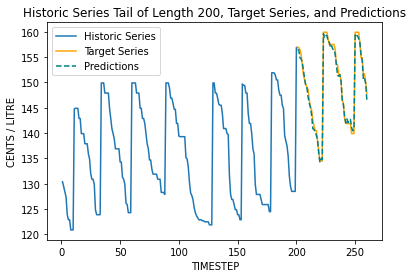

In [71]:
# Plot predictions versus targets for selected VALIDATION data.
predict_and_plot2(validation_input_price, validation_targets_price, validation_predictions_price, 1007 ,200)

In [37]:
# Mean absolute error.
print("Mean absolute error VALIDATION = ",np.mean(np.abs(np.subtract(validation_targets_price,\
                                          validation_predictions_price))))

# Mean absolute percentage error.
print("Mean absolute % error VALIDATION = ", np.mean( np.abs(np.subtract(validation_targets_price,\
                  validation_predictions_price)/validation_targets_price)*100 ) )

Mean absolute error VALIDATION =  1.9067869340037917
Mean absolute % error VALIDATION =  1.3413701905314548


In [0]:
# Normalise test historic data with train std and mean.
test_input_data = transform_series_other(test_series[:,:window], train_series_mean, train_series_std)

# Normalise test target data with train std and mean.
test_target_data = transform_series_other(test_series[:,window:], train_series_mean, train_series_std)

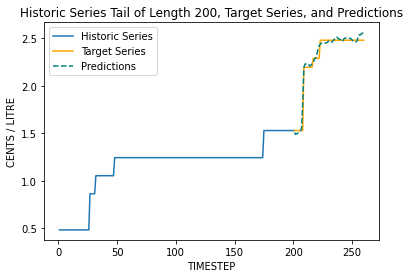

In [74]:
# Plot predictions versus targets for selected TEST data.
predict_and_plot(test_input_data, test_target_data, 1025, 200)

In [40]:
# Run the predictions on the test input data.
pred_array_test = predict_sequence(test_input_data)
print("Shape of test predictions: ",pred_array_test.shape)
print("Shape of test targets: ",test_target_data.shape)

Shape of test predictions:  (1961, 60, 1)
Shape of test targets:  (1961, 60, 1)


In [0]:
# De-normalise the test data.
test_input_price = transform_to_price(test_input_data, train_series_mean, train_series_std)
test_predictions_price = transform_to_price(pred_array_test, train_series_mean, train_series_std)
test_targets_price = transform_to_price(test_target_data, train_series_mean, train_series_std)

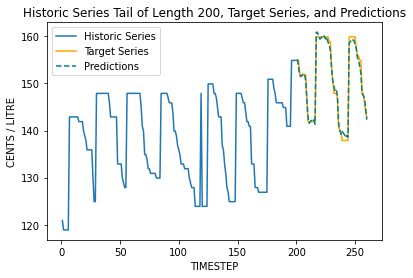

In [76]:
# Plot predictions versus targets for selected TEST data.
predict_and_plot2(test_input_price, test_targets_price, test_predictions_price, 14,200)

In [43]:
# Mean absolute error.
print("Mean absolute error TEST = ",np.mean(np.abs(np.subtract(test_targets_price,\
                                          test_predictions_price))))

# Mean absolute percentage error.
print("Mean absolute % error TEST = ", np.mean( np.abs(np.subtract(test_targets_price,\
                  test_predictions_price)/test_targets_price)*100 ) )

Mean absolute error TEST =  1.9577308017200878
Mean absolute % error TEST =  1.3772243050595399
